In [214]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [215]:
class MnistModel(nn.Module):
    def __init__(self):
        super(MnistModel, self).__init__()
        self._model = nn.Sequential(
            self._block(1, 20, 5),
            self._block(20, 40, 5),
            nn.Flatten(),
            nn.Dropout(), # Можно попробовать изменить p
            nn.Linear(7 * 7 * 40, 100),
            nn.Linear(100, 10)
        )

    @staticmethod
    def _block(dim_in: int, dim_out: int, kernel_size: int = 5, padding: int = 2, kernel_size_MaxPool2d=2) -> nn.Module:
        return nn.Sequential(
           nn.Conv2d(dim_in, dim_out, kernel_size, padding=padding),
           nn.ReLU(),
           nn.MaxPool2d(kernel_size=kernel_size_MaxPool2d)
        )

    def forward(self, x):
        x = self._model(x)
        return x

model_template = MnistModel()
print(model_template)

MnistModel(
  (_model): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(20, 40, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): Flatten(start_dim=1, end_dim=-1)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=1960, out_features=100, bias=True)
    (5): Linear(in_features=100, out_features=10, bias=True)
  )
)


In [216]:
for p in model_template.parameters():
    print(p.size())

torch.Size([20, 1, 5, 5])
torch.Size([20])
torch.Size([40, 20, 5, 5])
torch.Size([40])
torch.Size([100, 1960])
torch.Size([100])
torch.Size([10, 100])
torch.Size([10])


In [217]:
num_epochs = 8
batch_size = 200
learning_rate = 0.0002
"""
Для построения кривой обучения производите измерения точности на тестовом
наборе данных через каждые 10000/«размер пакета» итераций.
10**4 - по-умолчанию
> 10**4 - для медленных обучений
"""
freq_res_output = 10**4

optimizer_func = optim.Adam

# criterion = nn.NLLLoss()
criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [218]:
train_loader_mnist = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=True, download=True, transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True
)
test_loader_mnist = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=False, transform=transforms.ToTensor()),
    batch_size=batch_size
)

train_loader_fashion_mnist = torch.utils.data.DataLoader(
    datasets.FashionMNIST('data', train=True, download=True, transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True
)
test_loader_fashion_mnist = torch.utils.data.DataLoader(
    datasets.FashionMNIST('data', train=False, transform=transforms.ToTensor()),
    batch_size=batch_size
)


In [219]:
def find_conv2d_layers_and_frozen_params(model, requires_grad):
    for layer in model.children():
        if isinstance(layer, nn.Conv2d):
            for param in layer.parameters():
                param.requires_grad = requires_grad
        elif isinstance(layer, nn.Sequential):
            find_conv2d_layers_and_frozen_params(layer, requires_grad)

def test(model, test_loader):
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            out = model(data)
            test_loss += criterion(out, target).item()
            _, predicted = torch.max(out.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    return 100. * correct / total, test_loss / len(test_loader.dataset)


def train(model, optimizer, train_loader, test_loader, frozen_part=(-1, -1)):

    model.train()
    total_step = len(train_loader) * num_epochs
    loss_list = []
    acc_list = []

    def inner_test():
        model.eval()
        acc, loss = test(model, test_loader)
        loss_list.append((i, loss))
        acc_list.append((i, acc))
        model.train()

        print('Epoch [{}/{}], Step [{}/{}], Loss: {:.6f}, Accuracy: {:.2f}%'
              .format(epoch, num_epochs, i, total_step, loss, acc)
        )

    i = 0
    for epoch in range(1, num_epochs + 1):
        if frozen_part[0] <= epoch / num_epochs <= frozen_part[1]:
            frozen_text = "На этой эпохе ЗАМОРОЖЕНЫ все conv2d слои."
            find_conv2d_layers_and_frozen_params(model, False)
        else:
            frozen_text = "На этой эпохе разморожены все conv2d слои."
            find_conv2d_layers_and_frozen_params(model, True)
        print(f"Начинаем эпоху номер {epoch}. {frozen_text}")
        for i, (data, target) in enumerate(train_loader, start=i+1):
            outputs = model(data)
            loss = criterion(outputs, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if i % (freq_res_output // batch_size) == 0: # Выводить результат каждую 10**4 / batch_size итерацию
                inner_test()

    if i % (freq_res_output // batch_size) != 0:
        inner_test()

    return loss_list, acc_list

In [220]:
def plot_loss_and_acc(loss_list, acc_list, step = len(train_loader_mnist), max_step =len(train_loader_mnist) * num_epochs):
    loss_iter, loss_list = zip(*loss_list)
    acc_iter, acc_list = zip(*acc_list)

    for x in range(step, max_step, step):
        plt.axvline(x=x, linestyle=':', color='r')
    plt.plot(loss_iter, loss_list)
    plt.title("График эмпирического риска")
    plt.xlabel("Итерация")
    plt.ylabel("Loss")
    plt.show()

    for x in range(step, max_step, step):
        plt.axvline(x=x, linestyle=':', color='r')
    plt.plot(acc_iter, acc_list)
    plt.title("График качества")
    plt.xlabel("Итерация")
    plt.ylabel("Точность в процентах")
    plt.show()


## Пункт 1
Придумайте архитектуру свёрточной сети для решения задачи классификации
на наборе данных MNIST. Обучите и протестируйте её. Постройте кривую
обучения. Сохраните полученные параметры.

In [221]:
model1 = MnistModel()
optimizer1 = optimizer_func(model1.parameters(), lr=learning_rate)
loss_list1, acc_list1 = train(model1, optimizer1, train_loader_mnist, test_loader_mnist)

Начинаем эпоху номер 1. На этой эпохе разморожены все conv2d слои.
Epoch [1/8], Step [50/2400], Loss: 0.005322, Accuracy: 77.56%
Epoch [1/8], Step [100/2400], Loss: 0.002186, Accuracy: 88.19%
Epoch [1/8], Step [150/2400], Loss: 0.001631, Accuracy: 90.96%
Epoch [1/8], Step [200/2400], Loss: 0.001311, Accuracy: 92.69%
Epoch [1/8], Step [250/2400], Loss: 0.001124, Accuracy: 93.53%
Epoch [1/8], Step [300/2400], Loss: 0.000966, Accuracy: 94.45%
Начинаем эпоху номер 2. На этой эпохе разморожены все conv2d слои.
Epoch [2/8], Step [350/2400], Loss: 0.000872, Accuracy: 94.88%
Epoch [2/8], Step [400/2400], Loss: 0.000780, Accuracy: 95.44%
Epoch [2/8], Step [450/2400], Loss: 0.000685, Accuracy: 96.03%
Epoch [2/8], Step [500/2400], Loss: 0.000641, Accuracy: 96.30%
Epoch [2/8], Step [550/2400], Loss: 0.000582, Accuracy: 96.49%
Epoch [2/8], Step [600/2400], Loss: 0.000538, Accuracy: 96.72%
Начинаем эпоху номер 3. На этой эпохе разморожены все conv2d слои.
Epoch [3/8], Step [650/2400], Loss: 0.000515

In [222]:
# Сохраняем модель для будущих пунктов
filepath_model1 = "model1.save"
torch.save(model1.state_dict(), filepath_model1)

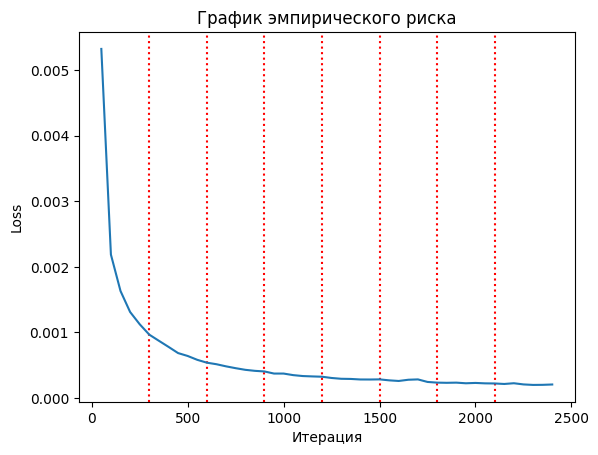

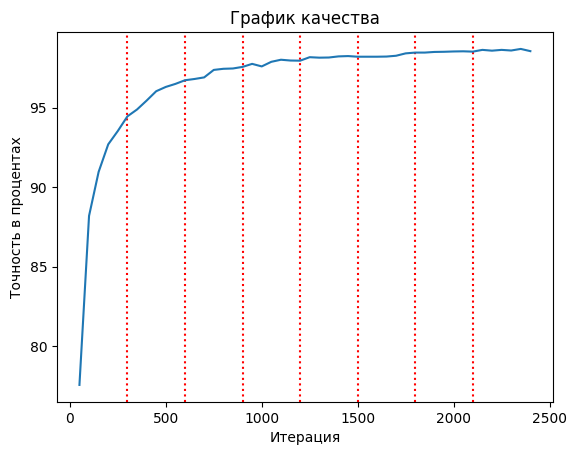

In [223]:
plot_loss_and_acc(loss_list1, acc_list1)

## Пункт 2
Обучите и протестируйте ту же самую архитектуру на наборе данных
Fashion-MNIST. Постройте кривую обучения.


In [224]:
model2 = MnistModel()
optimizer2 = optimizer_func(model2.parameters(), lr = 5 * learning_rate)
loss_list2, acc_list2 = train(model2, optimizer2, train_loader_fashion_mnist, test_loader_fashion_mnist)

Начинаем эпоху номер 1. На этой эпохе разморожены все conv2d слои.
Epoch [1/8], Step [50/2400], Loss: 0.003202, Accuracy: 75.31%
Epoch [1/8], Step [100/2400], Loss: 0.002668, Accuracy: 80.18%
Epoch [1/8], Step [150/2400], Loss: 0.002360, Accuracy: 83.02%
Epoch [1/8], Step [200/2400], Loss: 0.002277, Accuracy: 83.74%
Epoch [1/8], Step [250/2400], Loss: 0.002117, Accuracy: 85.24%
Epoch [1/8], Step [300/2400], Loss: 0.002092, Accuracy: 84.89%
Начинаем эпоху номер 2. На этой эпохе разморожены все conv2d слои.
Epoch [2/8], Step [350/2400], Loss: 0.001952, Accuracy: 86.12%
Epoch [2/8], Step [400/2400], Loss: 0.001920, Accuracy: 86.27%
Epoch [2/8], Step [450/2400], Loss: 0.001863, Accuracy: 86.98%
Epoch [2/8], Step [500/2400], Loss: 0.001776, Accuracy: 87.22%
Epoch [2/8], Step [550/2400], Loss: 0.001795, Accuracy: 87.11%
Epoch [2/8], Step [600/2400], Loss: 0.001675, Accuracy: 88.00%
Начинаем эпоху номер 3. На этой эпохе разморожены все conv2d слои.
Epoch [3/8], Step [650/2400], Loss: 0.001678

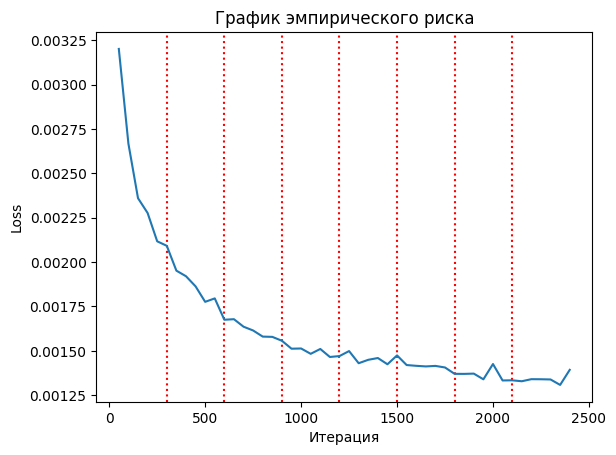

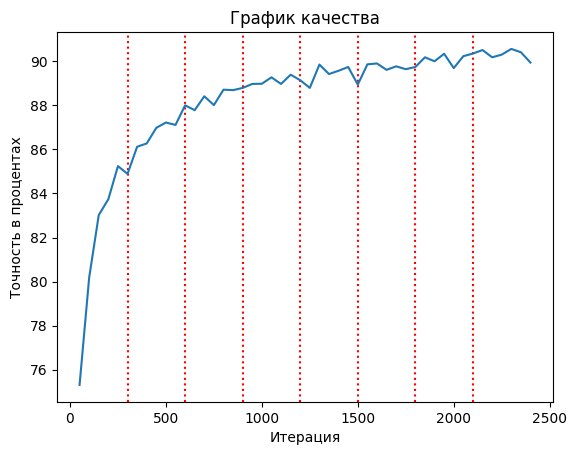

In [225]:
plot_loss_and_acc(loss_list2, acc_list2)

## Пункт 3
Повторите предыдущий эксперимент, но начните обучения не со случайных
параметров, а с сохранённых в первом пункте.

In [226]:
model3 = MnistModel()
model3.load_state_dict(torch.load(filepath_model1))
optimizer3 = optimizer_func(model3.parameters(), lr = 5 * learning_rate)
loss_list3, acc_list3 = train(model3, optimizer3, train_loader_fashion_mnist, test_loader_fashion_mnist)

Начинаем эпоху номер 1. На этой эпохе разморожены все conv2d слои.
Epoch [1/8], Step [50/2400], Loss: 0.003053, Accuracy: 78.17%
Epoch [1/8], Step [100/2400], Loss: 0.002821, Accuracy: 78.51%
Epoch [1/8], Step [150/2400], Loss: 0.002424, Accuracy: 81.98%
Epoch [1/8], Step [200/2400], Loss: 0.002220, Accuracy: 84.61%
Epoch [1/8], Step [250/2400], Loss: 0.002044, Accuracy: 85.57%
Epoch [1/8], Step [300/2400], Loss: 0.001980, Accuracy: 86.21%
Начинаем эпоху номер 2. На этой эпохе разморожены все conv2d слои.
Epoch [2/8], Step [350/2400], Loss: 0.001987, Accuracy: 85.50%
Epoch [2/8], Step [400/2400], Loss: 0.001883, Accuracy: 86.64%
Epoch [2/8], Step [450/2400], Loss: 0.001899, Accuracy: 86.60%
Epoch [2/8], Step [500/2400], Loss: 0.001825, Accuracy: 86.84%
Epoch [2/8], Step [550/2400], Loss: 0.001754, Accuracy: 87.63%
Epoch [2/8], Step [600/2400], Loss: 0.001744, Accuracy: 87.67%
Начинаем эпоху номер 3. На этой эпохе разморожены все conv2d слои.
Epoch [3/8], Step [650/2400], Loss: 0.001736

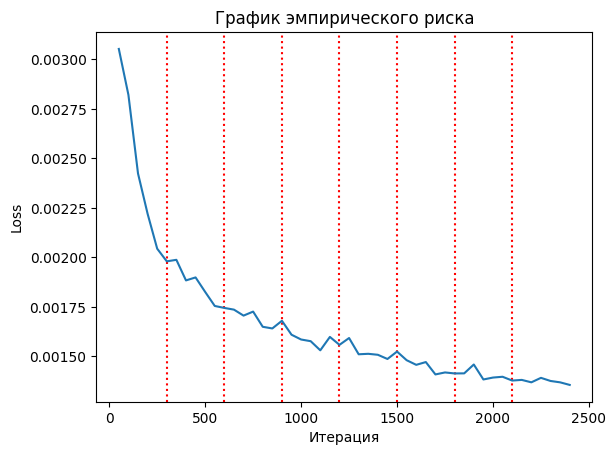

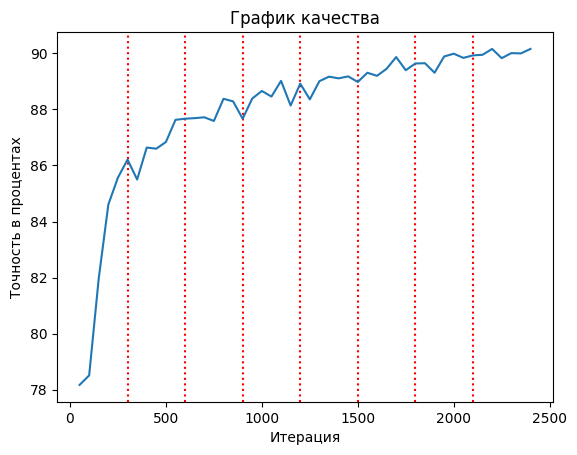

In [227]:
plot_loss_and_acc(loss_list3, acc_list3)

## Пункт 4
Повторите предыдущий эксперимент, но заморозьте параметры на свёрточных
слоях.

In [228]:
model4 = MnistModel()
model4.load_state_dict(torch.load(filepath_model1))
optimizer4 = optimizer_func(model4.parameters(), lr = 5 * learning_rate)
loss_list4, acc_list4 = train(model4, optimizer4, train_loader_fashion_mnist, test_loader_fashion_mnist, frozen_part=(0, 1))

Начинаем эпоху номер 1. На этой эпохе ЗАМОРОЖЕНЫ все conv2d слои.
Epoch [1/8], Step [50/2400], Loss: 0.003010, Accuracy: 79.03%
Epoch [1/8], Step [100/2400], Loss: 0.002580, Accuracy: 81.15%
Epoch [1/8], Step [150/2400], Loss: 0.002401, Accuracy: 83.35%
Epoch [1/8], Step [200/2400], Loss: 0.002277, Accuracy: 83.66%
Epoch [1/8], Step [250/2400], Loss: 0.002167, Accuracy: 85.14%
Epoch [1/8], Step [300/2400], Loss: 0.002168, Accuracy: 84.86%
Начинаем эпоху номер 2. На этой эпохе ЗАМОРОЖЕНЫ все conv2d слои.
Epoch [2/8], Step [350/2400], Loss: 0.002079, Accuracy: 85.47%
Epoch [2/8], Step [400/2400], Loss: 0.002098, Accuracy: 84.88%
Epoch [2/8], Step [450/2400], Loss: 0.001992, Accuracy: 86.18%
Epoch [2/8], Step [500/2400], Loss: 0.002042, Accuracy: 85.81%
Epoch [2/8], Step [550/2400], Loss: 0.002032, Accuracy: 85.29%
Epoch [2/8], Step [600/2400], Loss: 0.001956, Accuracy: 86.50%
Начинаем эпоху номер 3. На этой эпохе ЗАМОРОЖЕНЫ все conv2d слои.
Epoch [3/8], Step [650/2400], Loss: 0.001975, A

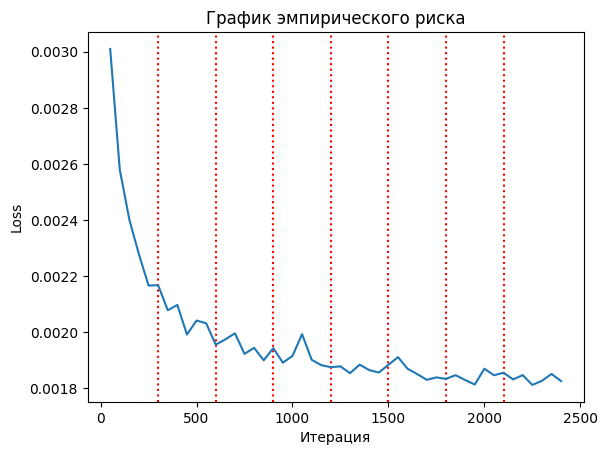

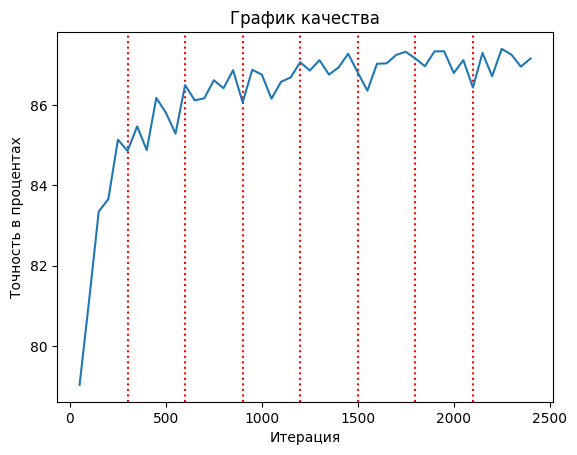

In [229]:
plot_loss_and_acc(loss_list4, acc_list4)

## Пункт 5
Повторите предыдущий эксперимент, но после нескольких эпох разморозьте и
дообучите параметры.

In [230]:
model5 = MnistModel()
model5.load_state_dict(torch.load(filepath_model1))
optimizer5 = optimizer_func(model5.parameters(), lr = 5 * learning_rate)
loss_list5, acc_list5 = train(model5, optimizer5, train_loader_fashion_mnist, test_loader_fashion_mnist, frozen_part=(0, 0.5))

Начинаем эпоху номер 1. На этой эпохе ЗАМОРОЖЕНЫ все conv2d слои.
Epoch [1/8], Step [50/2400], Loss: 0.002974, Accuracy: 79.34%
Epoch [1/8], Step [100/2400], Loss: 0.002529, Accuracy: 82.22%
Epoch [1/8], Step [150/2400], Loss: 0.002345, Accuracy: 83.68%
Epoch [1/8], Step [200/2400], Loss: 0.002287, Accuracy: 83.72%
Epoch [1/8], Step [250/2400], Loss: 0.002166, Accuracy: 85.03%
Epoch [1/8], Step [300/2400], Loss: 0.002160, Accuracy: 84.67%
Начинаем эпоху номер 2. На этой эпохе ЗАМОРОЖЕНЫ все conv2d слои.
Epoch [2/8], Step [350/2400], Loss: 0.002108, Accuracy: 85.19%
Epoch [2/8], Step [400/2400], Loss: 0.002039, Accuracy: 85.89%
Epoch [2/8], Step [450/2400], Loss: 0.002046, Accuracy: 85.48%
Epoch [2/8], Step [500/2400], Loss: 0.001992, Accuracy: 86.31%
Epoch [2/8], Step [550/2400], Loss: 0.001972, Accuracy: 86.36%
Epoch [2/8], Step [600/2400], Loss: 0.001992, Accuracy: 85.85%
Начинаем эпоху номер 3. На этой эпохе ЗАМОРОЖЕНЫ все conv2d слои.
Epoch [3/8], Step [650/2400], Loss: 0.001967, A

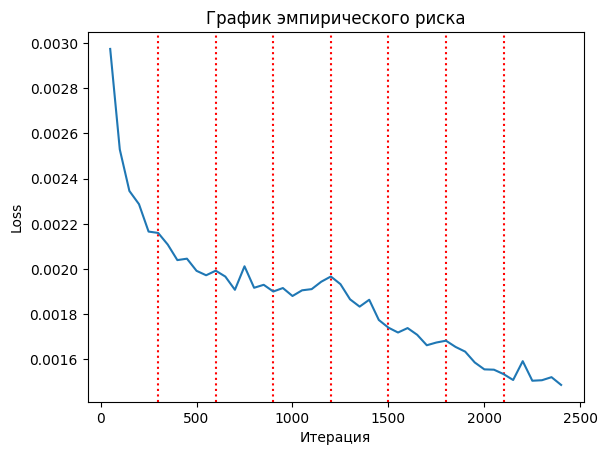

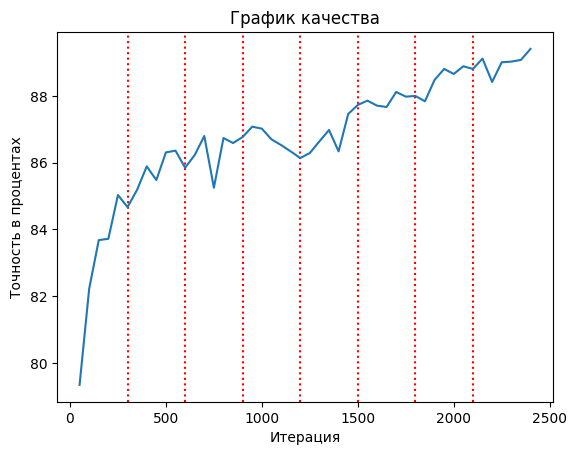

In [231]:
plot_loss_and_acc(loss_list5, acc_list5)

# Итоги
Построим график, объединяющий все остальные графики

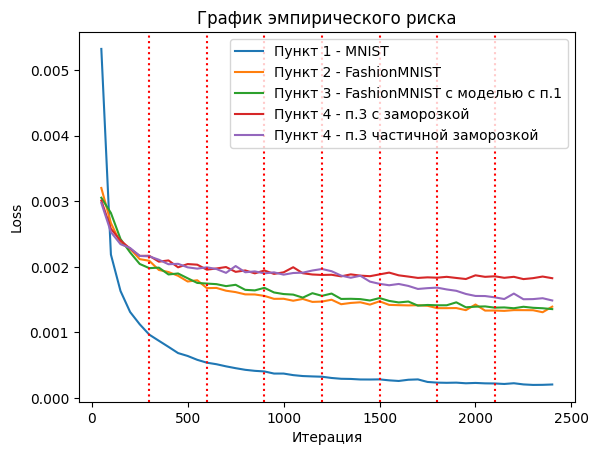

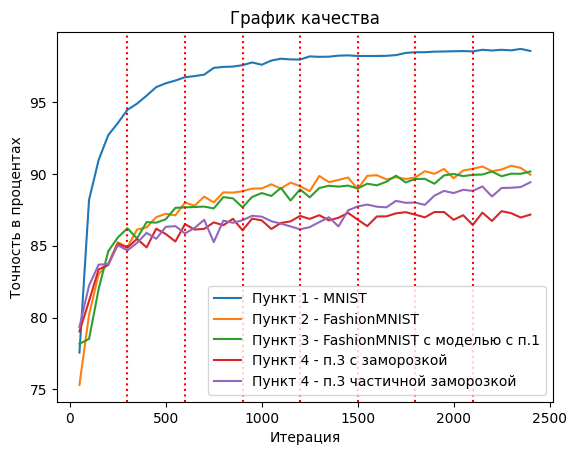

In [234]:
# def plot_loss_and_acc(loss_list, acc_list, step = len(train_loader_mnist), max_step =len(train_loader_mnist) * num_epochs):
#     loss_iter, loss_list = zip(*loss_list)
#     acc_iter, acc_list = zip(*acc_list)
#
#     for x in range(step, max_step, step):
#         plt.axvline(x=x, linestyle=':', color='r')
#     plt.plot(loss_iter, loss_list)
#     plt.title("График эмпирического риска")
#     plt.xlabel("Итерация")
#     plt.ylabel("Loss")
#     plt.show()
#
#     for x in range(step, max_step, step):
#         plt.axvline(x=x, linestyle=':', color='r')
#     plt.plot(acc_iter, acc_list)
#     plt.title("График качества")
#     plt.xlabel("Итерация")
#     plt.ylabel("Точность в процентах")
#     plt.show()

def plot_list(_list):
    _iter, _list = zip(*_list)
    plt.plot(_iter, _list)

step = len(train_loader_mnist)
max_step =len(train_loader_mnist) * num_epochs

for l in (
    loss_list1,
    loss_list2,
    loss_list3,
    loss_list4,
    loss_list5,
):
    plot_list(l)
legend = (
    "Пункт 1 - MNIST",
    "Пункт 2 - FashionMNIST",
    "Пункт 3 - FashionMNIST с моделью с п.1",
    "Пункт 4 - п.3 с заморозкой",
    "Пункт 5 - п.3 с частичной заморозкой",
)
plt.legend(legend)
for x in range(step, max_step, step):
        plt.axvline(x=x, linestyle=':', color='r')
plt.title("График эмпирического риска")
plt.xlabel("Итерация")
plt.ylabel("Loss")
plt.show()


for l in (
    acc_list1,
    acc_list2,
    acc_list3,
    acc_list4,
    acc_list5,
):
    plot_list(l)
plt.legend(legend)
for x in range(step, max_step, step):
        plt.axvline(x=x, linestyle=':', color='r')
plt.title("График качества")
plt.xlabel("Итерация")
plt.ylabel("Точность в процентах")
plt.show()